# Weekly task 2 - Dicky Adi

## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from tqdm import tqdm

## Read and basic knowledge of the dataset

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
cols = df.columns.to_list()

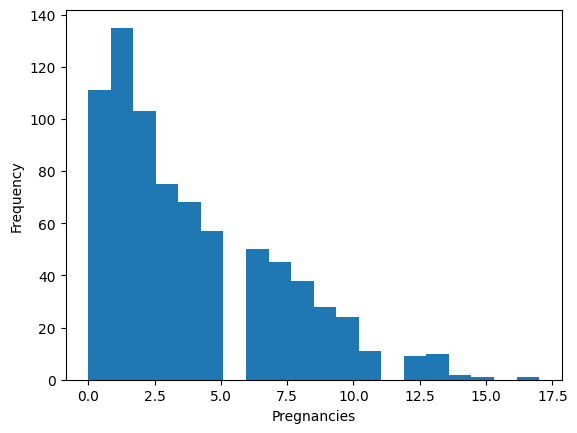

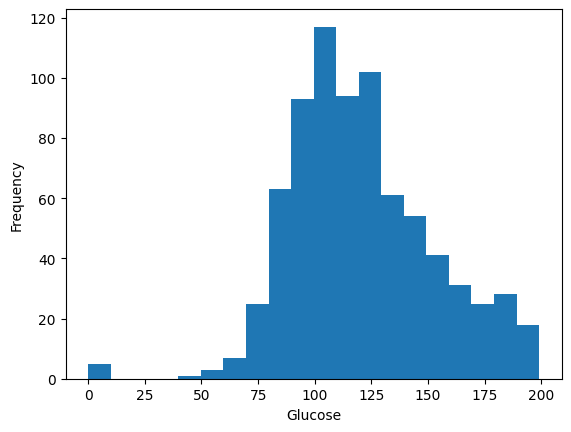

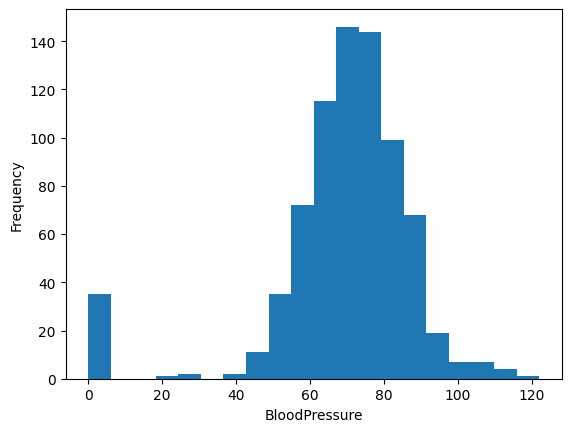

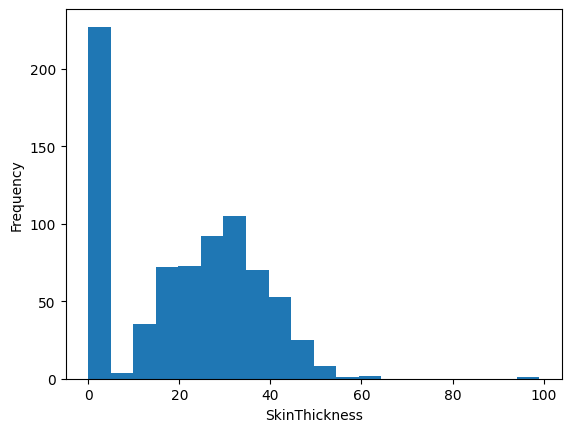

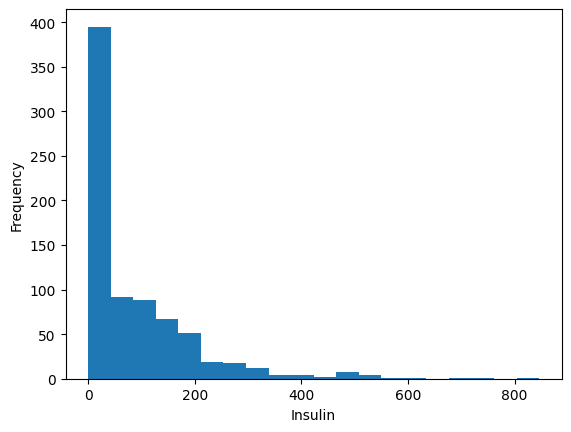

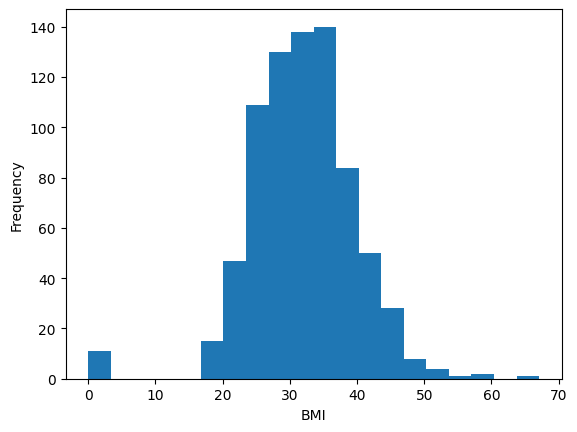

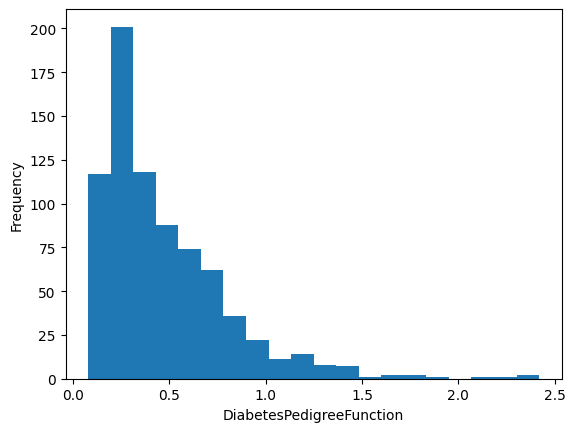

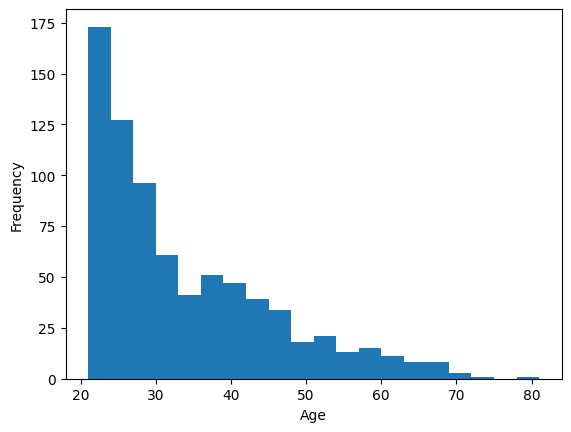

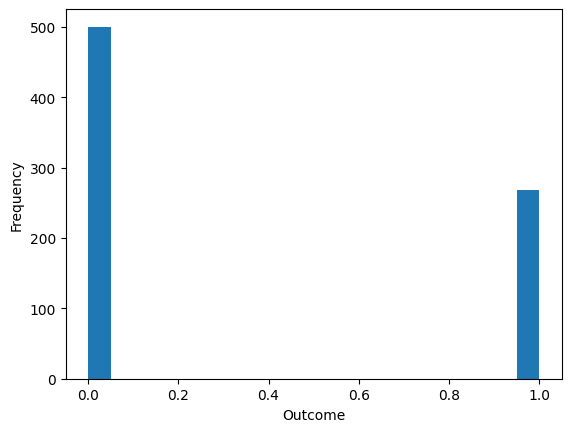

In [7]:
for col in cols:
    plt.hist(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Outliers handling

Based on above histogram visualization, seems like there're some outliers. However, to be precise lets check the boxplot visualization

<function matplotlib.pyplot.show(close=None, block=None)>

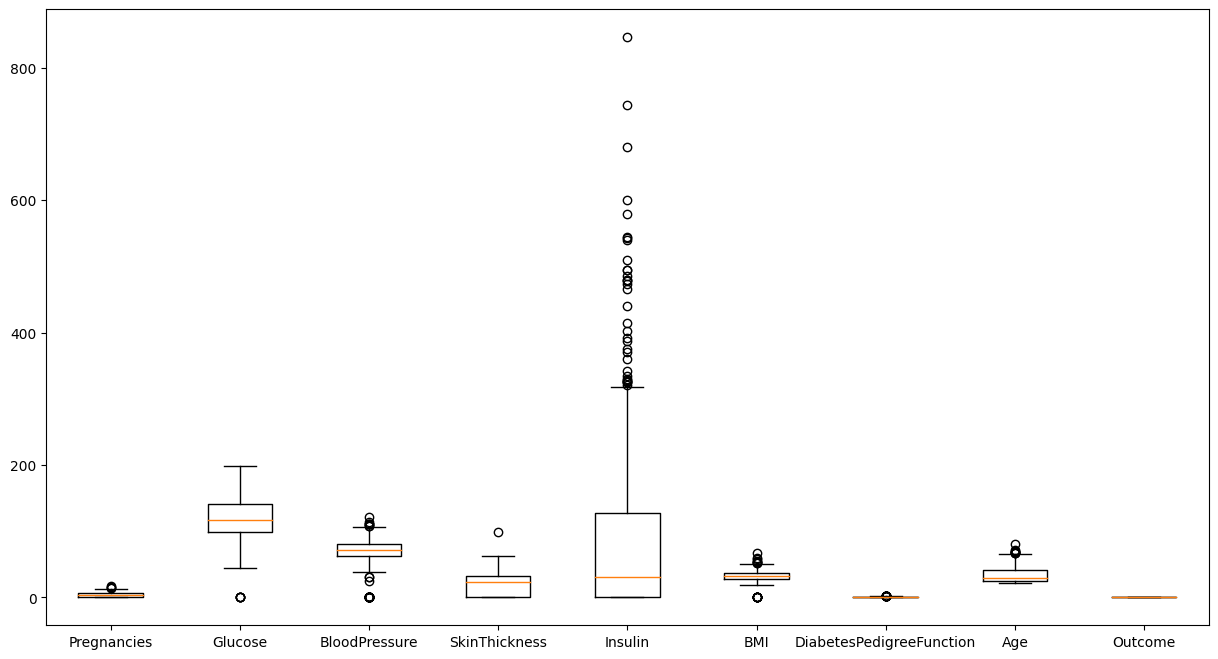

In [8]:
plt.figure(figsize=(15,8))
plt.boxplot(df.values)
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.show

Based on boxplot visualization above, there're a lot of outliers. Therefore we need to handle these outliers carefully by logging the outliers, but before we do that let's get the outliers value

In [9]:
threshold = 2
multiplier = 1.5

dfOutliers = df.copy(deep=True)
# colsOut = df.drop(['Age', 'Outcome'], axis=1).columns.to_list()

for col in dfOutliers.drop(['Age', 'Outcome'], axis=1).columns.to_list():
    # mean = df[col].mean()
    # std = df[col].std()
    # outliers = df[col][(df[col] - mean).abs() > threshold * std]
    # dfOutliers.loc[outliers.index, col] = np.log(outliers)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    # outliers = df[column][(df[column] < Q1 - multiplier * IQR) | (df[column] > Q3 + multiplier * IQR)]
    outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    if outliers.dtype == 'int64':
        dfOutliers.loc[outliers.index, col] = round(np.log(outliers + 1e-10))
    else:
        dfOutliers.loc[outliers.index, col] = np.log(outliers + 1e-10)

dfOutliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627000,50,1
1,1,85,66,29,0,26.6,0.351000,31,0
2,8,183,64,0,0,23.3,0.672000,32,1
3,1,89,66,23,94,28.1,0.167000,21,0
4,0,137,40,35,168,43.1,0.827678,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171000,63,0
764,2,122,70,27,0,36.8,0.340000,27,0
765,5,121,72,23,112,26.2,0.245000,30,0
766,1,126,60,0,0,30.1,0.349000,47,1


## EDA

In [11]:
dfOutliers.groupby('Outcome').count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


Based on table above, seems like we're having an imbalance dataset

In [13]:
dfOutliers.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.842000,66.564000,19.664000,55.754000,29.686545,0.402329,31.190000
1,4.686567,141.085821,67.776119,21.813433,67.458955,33.792707,0.479117,37.067164


Based on the table above, seems like the the predicted diabetic has higher mean in almost all columns

<Axes: >

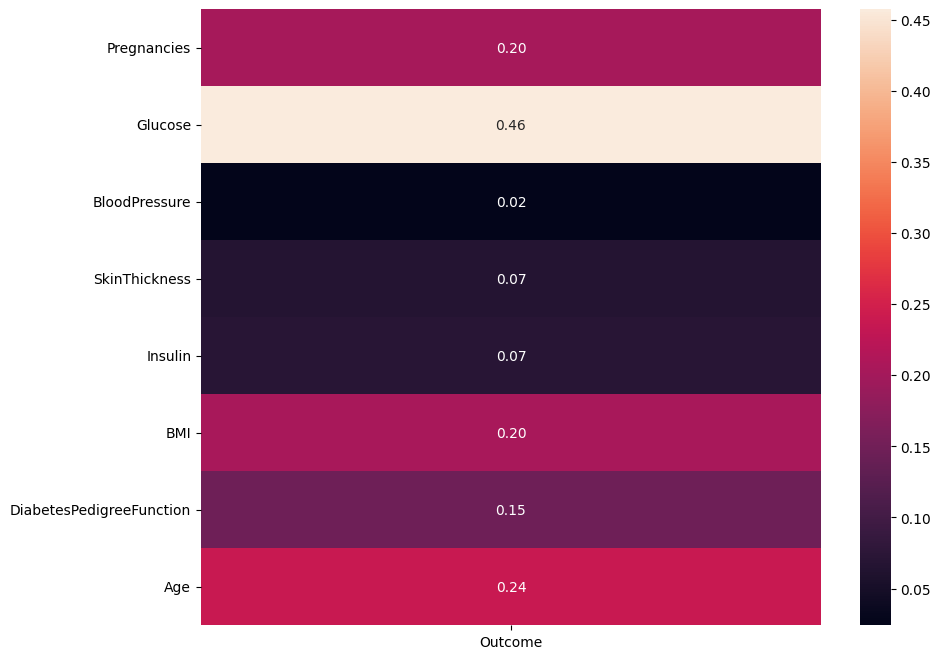

In [28]:
target = 'Outcome'
corr = dfOutliers.corr()[target]
corr = corr.drop(target)
dfCorr = pd.DataFrame(corr)
plt.figure(figsize=(10,8))
sns.heatmap(dfCorr, annot=True, fmt='.2f')

In [33]:
highCorr = dfCorr[abs(dfCorr) >= 0.2].dropna().index

In [34]:
print(highCorr)

Index(['Pregnancies', 'Glucose', 'BMI', 'Age'], dtype='object')


In [40]:
allCols = dfOutliers.copy(deep=True)
highCols = pd.concat([dfOutliers[highCorr], dfOutliers['Outcome']], axis=1)

In [41]:
allCols

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627000,50,1
1,1,85,66,29,0,26.6,0.351000,31,0
2,8,183,64,0,0,23.3,0.672000,32,1
3,1,89,66,23,94,28.1,0.167000,21,0
4,0,137,40,35,168,43.1,0.827678,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171000,63,0
764,2,122,70,27,0,36.8,0.340000,27,0
765,5,121,72,23,112,26.2,0.245000,30,0
766,1,126,60,0,0,30.1,0.349000,47,1


In [42]:
highCols

,Pregnancies,Glucose,BMI,Age,Outcome
0,6,148,33.6,50,1
1,1,85,26.6,31,0
2,8,183,23.3,32,1
3,1,89,28.1,21,0
4,0,137,43.1,33,1
...,...,...,...,...,...
763,10,101,32.9,63,0
764,2,122,36.8,27,0
765,5,121,26.2,30,0
766,1,126,30.1,47,1


## Modelling